In [15]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

from qiskit.tools.visualization import plot_histogram
from qiskit_aqua import Operator, run_algorithm, get_algorithm_instance
from qiskit_aqua.input import get_input_instance
from qiskit_aqua.ising import maxcut, tsp
from qiskit import Aer, IBMQ, available_backends, execute

import logging
logger = logging.getLogger("qiskit.tools.visualization")
logger.setLevel(logging.ERROR) # disable unecessary warnings
# logger.setLevel(logging.DEBUG) # uncomment it to see detailed logging

In [16]:
# Authenticate with your IBMQ Credentials to use IBM Q backends.
# This step is not mandatory, and the code can be executed with a local simulator as well.
#APItoken = ''
#ProjectURL = ''

# Alternatively you can enable your account without saving it.
#IBMQ.enable_account(APItoken, ProjectURL)

In [17]:
# See a list of available backends
print("Local backends: ", Aer.backends()) # Local backend (simulator only)
#print("IBMQ backends: ", IBMQ.backends()) # IBMQ backends

Local backends:  [<QasmSimulator('qasm_simulator') from Aer()>, <QasmSimulatorPy('qasm_simulator_py') from Aer()>, <StatevectorSimulator('statevector_simulator') from Aer()>, <StatevectorSimulatorPy('statevector_simulator_py') from Aer()>, <UnitarySimulator('unitary_simulator') from Aer()>, <CliffordSimulator('clifford_simulator') from Aer()>]


distance
 [[ 0. 17. 70. 33.]
 [17.  0. 80. 50.]
 [70. 80.  0. 58.]
 [33. 50. 58.  0.]]


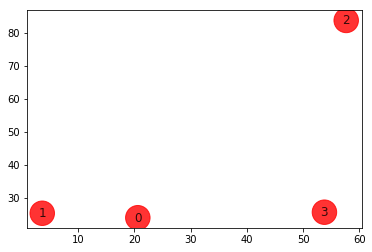

In [18]:
# Generating a random graph of 4 nodes

n = 4
num_qubits = n ** 2
ins = tsp.random_tsp(n)
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
colors = ['r' for node in G.nodes()]
pos = {k: v for k, v in enumerate(ins.coord)}
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
print('distance\n', ins.w)

In [19]:
# Mapping to the Ising problem
qubitOp, offset = tsp.get_tsp_qubitops(ins)
algo_input = get_input_instance('EnergyInput')
algo_input.qubit_op = qubitOp

In [20]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector

algorithm_cfg = {
    'name': 'ExactEigensolver',
}

params = {
    'problem': {'name': 'ising'},
    'algorithm': algorithm_cfg
}

result = run_algorithm(params,algo_input)
print('energy:', result['energy'])
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

energy: -1600428.0
feasible: True
solution: [3, 2, 1, 0]
solution objective: 188.0


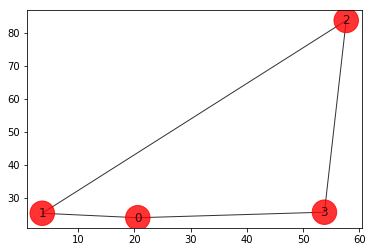

In [21]:
def draw_tsp_solution(G, order, colors, pos):
    # draws the solution of the TSP on the graph
    G2 = G.copy()
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

draw_tsp_solution(G, z, colors, pos)


### Running it on quantum computer
We run the optimization routine using a feedback loop with a quantum computer that uses trial functions built with Y single-qubit rotations, $U_\mathrm{single}(\theta) = \prod_{i=1}^n Y(\theta_{i})$, and entangler steps $U_\mathrm{entangler}$.

In [22]:
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': 10598},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'name': 'statevector_simulator'}
}

result = run_algorithm(params,algo_input)
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(G, z, colors, pos)


/Users/hassan.naseri/.pyenv/versions/3.6.5/Python.framework/Versions/3.6/lib/python3.6/site-packages/qiskit/wrapper/_wrapper.py:111: DeprecationWarning: registered_providers() will be deprecated after 0.6. Please use the qiskit.IBMQ.active_accounts() method instead.
  DeprecationWarning)
/Users/hassan.naseri/.pyenv/versions/3.6.5/Python.framework/Versions/3.6/lib/python3.6/site-packages/qiskit/wrapper/_wrapper.py:63: DeprecationWarning: The global registry of providers and register() is deprecated since 0.6. Please instantiate "<class 'qiskit.backends.ibmq.ibmqprovider.IBMQProvider'>()" directly.
  DeprecationWarning)
/Users/hassan.naseri/.pyenv/versions/3.6.5/Python.framework/Versions/3.6/lib/python3.6/site-packages/qiskit/wrapper/_wrapper.py:153: DeprecationWarning: available_backends() will be deprecated after 0.6. Please use the qiskit.IBMQ.backends() and qiskit.Aer.backends() method instead.
  DeprecationWarning)
/Users/hassan.naseri/.pyenv/versions/3.6.5/Python.framework/Versions

TypeError: 'method' object is not subscriptable